In [1]:
import os
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torchvision import datasets, models, transforms

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

##**Load dataset**

In [3]:
!gdown 1OJF-F5n83RxIYDC-wX4AUngpdAfbXacN
!unzip cats_and_dogs_large_imbalanced.zip

Streaming output truncated to the last 5000 lines.
  inflating: cats_and_dogs_large/train/dog/dog.8200.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8201.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8202.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8203.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8204.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8205.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8206.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8207.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8208.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8209.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.821.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8210.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8211.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8212.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8213.jpg  
  inflating: cats_and_dogs_large/train/dog/dog.8214.jpg  
  inflating: cats_and_

##**Preprocessing**

In [4]:
transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),   # Resize images to a fixed size
                transforms.ToTensor(),           # Convert images to PyTorch tensors
                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                     std=(0.5, 0.5, 0.5))
            ])

# Load datasets
train_dataset = datasets.ImageFolder('./cats_and_dogs_large/train', transform=transform)
test_dataset = datasets.ImageFolder('./cats_and_dogs_large/validation', transform=transform)

In [5]:
num_classes = 2

In [6]:
print(f'Numbers of Cat images: {train_dataset.targets.count(0)}')
print(f'Numbers of Dog images: {train_dataset.targets.count(1)}')

Numbers of Cat images: 1000
Numbers of Dog images: 11000


In [7]:
import random

# Get indices for 'Cat' and 'Dog' images
cat_indices = [i for i, label in enumerate(train_dataset.targets) if label == 0]
dog_indices = [i for i, label in enumerate(train_dataset.targets) if label == 1]

# Randomly sample 'Dog' images to match the number of 'Cat' images
random.seed(0)  # For reproducibility
dog_indices_sampled = random.sample(dog_indices, len(cat_indices)*2)

# Combine indices
balanced_indices = cat_indices + dog_indices_sampled

# Modify the original dataset's samples and targets to reflect the balanced dataset
train_dataset.samples = [train_dataset.samples[i] for i in balanced_indices]
train_dataset.targets = [train_dataset.targets[i] for i in balanced_indices]

In [8]:
# Verify the number of images in each class
print(f'Number of Cat images: {train_dataset.targets.count(0)}')
print(f'Number of Dog images: {train_dataset.targets.count(1)}')

Number of Cat images: 1000
Number of Dog images: 2000


In [9]:
X = []
Y = []

for img, label in train_dataset:
    X.append(img.numpy())
    Y.append(label)

X = np.array(X)
Y = np.array(Y)

In [10]:
X = X.reshape(-1, 3*224*224)

In [11]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_smote, y_smote = sm.fit_resample(X, Y)

In [12]:
X_smote = X_smote.reshape(X_smote.shape[0], 3, 224, 224)

In [13]:
X_smote.shape, y_smote.shape

((4000, 3, 224, 224), (4000,))

In [14]:
from torch.utils.data import TensorDataset, DataLoader

# Create a DataLoader
batch_size = 32  # Define your batch size
train_loader = DataLoader(TensorDataset(torch.tensor(X_smote), torch.tensor(y_smote)), batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [15]:
del X_smote
del y_smote
del X
del Y

In [16]:
inputs, labels = next(iter(train_loader))

In [17]:
inputs.shape

torch.Size([64, 3, 224, 224])

In [18]:
len(train_loader)

63

##**Trainer**

In [19]:
from sklearn.metrics import classification_report

target_names = ["Cat", "Dog"]

def cls_report(running_target, running_preds, target_names):
    targets = np.hstack(running_target[:-1])
    targets = np.concatenate((targets, running_target[-1]))

    predicts =  np.hstack(running_preds[:-1])
    predicts = np.concatenate((predicts, running_preds[-1]))

    report = classification_report(targets, predicts,
                                   target_names=target_names,
                                   zero_division=0.0, output_dict=True)
    del report['weighted avg']
    return report

In [20]:
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=25):
    model.train()
    accs, losses = [], []
    start_time = time.time()
    running_target = []
    running_pred = []
    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        running_target.append(labels.cpu().numpy())

        optimizer.zero_grad()

        predictions = model(inputs)
        _, pred = torch.max(predictions, 1)
        running_pred.append(pred.cpu().numpy())

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()

        total_acc = (predictions.argmax(1) == labels).sum().item()
        acc = total_acc / labels.size(0)
        accs.append(acc)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), sum(accs) / len(accs)
                )
            )
            start_time = time.time()

    epoch_acc = sum(accs) / len(accs)
    epoch_loss = sum(losses) / len(losses)
    rp = cls_report(running_target, running_pred, target_names)
    return epoch_acc, epoch_loss, rp

In [21]:
def evaluate_epoch(model, criterion, valid_dataloader):
    model.eval()
    accs, losses = [], []
    running_target = []
    running_pred = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            running_target.append(labels.cpu().numpy())

            predictions = model(inputs)
            _, pred = torch.max(predictions, 1)
            running_pred.append(pred.cpu().numpy())

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc = (predictions.argmax(1) == labels).sum().item()
            acc = total_acc / labels.size(0)
            accs.append(acc)

    epoch_acc = sum(accs) / len(accs)
    epoch_loss = sum(losses) / len(losses)
    rp = cls_report(running_target, running_pred, target_names)
    return epoch_acc, epoch_loss, rp

In [22]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss, train_rp = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss, val_rp = evaluate_epoch(model, criterion, valid_dataloader)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)

        # Print loss, acc end epoch
        print("=" * 59)
        print(f"Epoch [{epoch}/{num_epochs}]")

        print(f"Train | loss: {train_loss:.4f}, accuracy: {train_acc:.4f}, accuracy_rp: {train_rp['accuracy']:.4f}")
        print(f"\tAvg | precision: {train_rp['macro avg']['precision']:.4f}, recall: {train_rp['macro avg']['recall']:.4f}, F1: {train_rp['macro avg']['f1-score']:.4f}")
        print(f"\tCat | precision: {train_rp['Cat']['precision']:.4f}, recall: {train_rp['Cat']['recall']:.4f}, F1: {train_rp['Cat']['f1-score']:.4f}")
        print(f"\tDog | precision: {train_rp['Cat']['precision']:.4f}, recall: {train_rp['Cat']['recall']:.4f}, F1: {train_rp['Cat']['f1-score']:.4f}")

        print(f"Valid | loss: {eval_loss:.4f}, accuracy: {eval_acc:.4f}, accuracy_rp: {val_rp['accuracy']:.4f}")
        print(f"\tAvg | precision: {val_rp['macro avg']['precision']:.4f}, recall: {val_rp['macro avg']['recall']:.4f}, F1: {val_rp['macro avg']['f1-score']:.4f}")
        print(f"\tCat | precision: {val_rp['Cat']['precision']:.4f}, recall: {val_rp['Cat']['recall']:.4f}, F1: {val_rp['Cat']['f1-score']:.4f}")
        print(f"\tDog | precision: {val_rp['Cat']['precision']:.4f}, recall: {val_rp['Cat']['recall']:.4f}, F1: {val_rp['Cat']['f1-score']:.4f}")
        print("=" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [23]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

##**Model**

In [24]:
model = models.resnet18(weights=None)

In [25]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

In [26]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
from torchsummary import summary
model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [29]:
predictions = model(inputs.to(device))

In [30]:
predictions.shape

torch.Size([64, 2])

In [31]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [32]:
base_model = models.resnet18(weights=None)
in_features = base_model.fc.in_features
base_model.fc = nn.Linear(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.0001)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'base_model'

base_model, base_metrics = train(
    base_model, model_name, save_model, optimizer, criterion, train_loader, test_loader, num_epochs, device
)

| epoch   1 |    25/   63 batches | accuracy    0.698
| epoch   1 |    50/   63 batches | accuracy    0.725
Epoch [1/50]
Train | loss: 0.5427, accuracy: 0.7264, accuracy_rp: 0.7265
	Avg | precision: 0.7265, recall: 0.7265, F1: 0.7265
	Cat | precision: 0.7267, recall: 0.7260, F1: 0.7264
	Dog | precision: 0.7267, recall: 0.7260, F1: 0.7264
Valid | loss: 0.6022, accuracy: 0.6843, accuracy_rp: 0.6843
	Avg | precision: 0.6978, recall: 0.6843, F1: 0.6789
	Cat | precision: 0.6462, recall: 0.8147, F1: 0.7207
	Dog | precision: 0.6462, recall: 0.8147, F1: 0.7207
| epoch   2 |    25/   63 batches | accuracy    0.816
| epoch   2 |    50/   63 batches | accuracy    0.814
Epoch [2/50]
Train | loss: 0.4026, accuracy: 0.8177, accuracy_rp: 0.8180
	Avg | precision: 0.8180, recall: 0.8180, F1: 0.8180
	Cat | precision: 0.8155, recall: 0.8220, F1: 0.8187
	Dog | precision: 0.8155, recall: 0.8220, F1: 0.8187
Valid | loss: 0.6690, accuracy: 0.6636, accuracy_rp: 0.6633
	Avg | precision: 0.6634, recall: 0.6633,

In [33]:
test_acc, test_loss, rp = evaluate_epoch(base_model, criterion, test_loader)
test_acc, test_loss, rp

(0.6975683890577508,
 1.4283614256914625,
 {'Cat': {'precision': 0.7642857142857142,
   'recall': 0.5706666666666667,
   'f1-score': 0.6534351145038167,
   'support': 1500},
  'Dog': {'precision': 0.6574468085106383,
   'recall': 0.824,
   'f1-score': 0.7313609467455621,
   'support': 1500},
  'accuracy': 0.6973333333333334,
  'macro avg': {'precision': 0.7108662613981762,
   'recall': 0.6973333333333334,
   'f1-score': 0.6923980306246894,
   'support': 3000}})

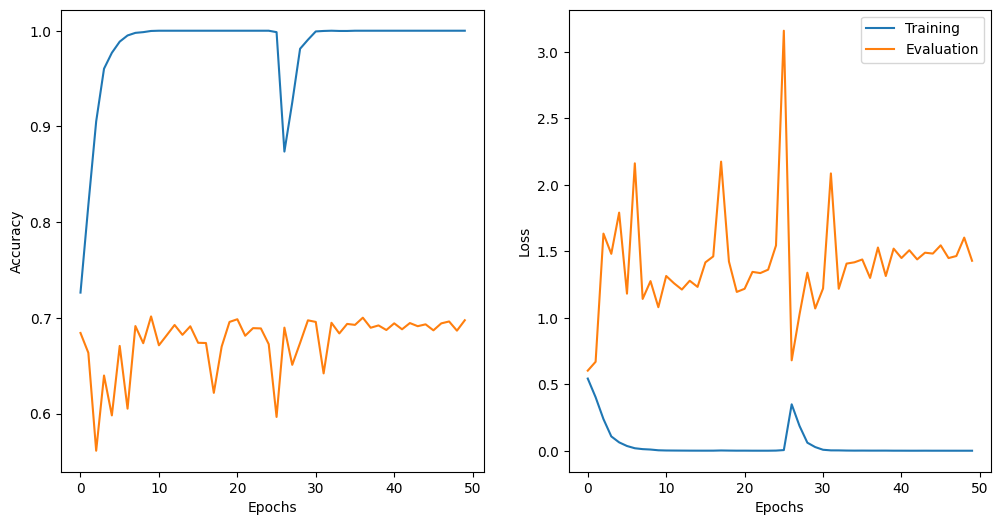

In [34]:
plot_result(
    num_epochs,
    base_metrics["train_accuracy"],
    base_metrics["valid_accuracy"],
    base_metrics["train_loss"],
    base_metrics["valid_loss"]
)